In [1]:
import pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns',500)
import matplotlib.pyplot as plt

### Load cleaned and feature engineered datasets

In [2]:
#Read the train and test cleaned data with engineered features
train_copy_df = pd.read_csv('train_complete.csv')
test_copy_df = pd.read_csv('test_complete.csv')

In [3]:
train_copy_df.head()

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,DescrLength,Description,Dewormed,Fee,FurLength,Gender,Health,IsHealthy,IsMixedBreed,Magnitude,MaturitySize,Name,NameFrequency,NumColors,PetID,PhotoAmt,Quantity,RescuerID,Score,State,StateLevel,Sterilized,Type,Vaccinated,VideoAmt,WordCount,RescuerNumPosts,BreedRank,detectionConfidence,joyLikelihood,sorrowLikelihood,angerLikelihood,surpriseLikelihood,underExposedLikelihood,blurredLikelihood,headwearLikelihood,labels,street dog,dog like mammal,aegean cat,carnivoran,small to medium sized cats,cat like mammal,dog breed,snout,whiskers,domestic short haired cat,puppy,dog breed group,fauna,kitten,european shorthair,dog,sporting group,cat
0,2,3,299,0,1,7,0,359,Nibble is a 3+ month old ball of cuteness. He ...,2,100,1,1,1,7,0,2.4,1,Nibble,1,2,86e1089a3,1,1,3734,0.3,41326,0,2,2,2,0,69,8,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.000000,0.000000,0.0,0.000000,0.919535,0.894983,0.000000,0.000000,0.680083,0.74,0.000000,0.000000,0.000000,0.695694,0.0,0.000000,0.000000,0.990786
1,0,1,265,0,1,2,0,118,I just found it alone yesterday near my apartm...,3,0,2,1,1,10,0,0.7,2,No Name Yet,22,2,6296e909a,2,1,1408,-0.2,41401,1,3,2,3,0,23,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.000000,0.000000,0.0,0.000000,0.891908,0.834615,0.000000,0.672995,0.905297,0.00,0.000000,0.658263,0.841606,0.000000,0.0,0.000000,0.000000,0.981269
2,3,1,307,0,2,7,0,393,Their pregnant mother was dumped by her irresp...,1,0,2,1,1,5,0,3.7,2,Brisco,1,2,3422e4906,7,1,6965,0.2,41326,0,2,1,1,0,69,459,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.000000,0.941660,0.0,0.649802,0.000000,0.000000,0.941017,0.616009,0.000000,0.00,0.720260,0.903123,0.000000,0.000000,0.0,0.960457,0.000000,0.000000
3,2,4,307,0,1,2,0,146,"Good guard dog, very alert, active, obedience ...",1,150,1,2,1,5,0,0.9,2,Miko,11,2,5842f1ff5,8,1,4107,0.9,41401,1,2,1,1,0,25,50,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.583048,0.946035,0.0,0.655879,0.000000,0.000000,0.938040,0.677403,0.000000,0.00,0.858104,0.874950,0.000000,0.000000,0.0,0.978698,0.546364,0.000000
4,2,1,307,0,1,0,0,390,This handsome yet cute boy is up for adoption....,2,0,1,1,1,7,0,3.7,2,Hunter,5,1,850a43f90,3,1,4191,0.6,41326,0,2,1,2,0,81,134,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.000000,0.965755,0.0,0.661956,0.000000,0.000000,0.942495,0.783549,0.000000,0.00,0.932304,0.902654,0.000000,0.000000,0.0,0.984346,0.000000,0.000000


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
std_quantity = scaler.fit_transform(train_copy_df['Quantity'].values.reshape(-1,1))
train_copy_df['NormQuantity'] = std_quantity

std_quantity = scaler.fit_transform(test_copy_df['Quantity'].values.reshape(-1,1))
test_copy_df['NormQuantity'] = std_quantity

In [5]:
drop_cols = ['AdoptionSpeed','Description','Name','PetID','Quantity']

In [6]:
#Drop description, petid, name
y = train_copy_df['AdoptionSpeed']
X = train_copy_df.drop(drop_cols,axis=1)
test_X = test_copy_df.drop(drop_cols, axis=1)
print(X.shape,y.shape,test_X.shape)

(14993, 58) (14993,) (3948, 58)


In [7]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve,GroupKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [ ]:
# Define what will be the final predicted train and test values
train_meta = np.zeros(y.shape)
test_meta = np.zeros(test_X.shape[0])

#SMOTE over samplingg
#sm = SMOTE(random_state=12, kind='regular')

# Choose and initialize a model.
clf = XGBClassifier(max_depth=7,n_estimators=250,n_jobs=4)

# Divide the training data into k-folds, k=4 here.
splits = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=1812).split(X, y))

#splits = list(GroupKFold(n_splits=4).split(X, y, X['RescuerID']))

# Loop over the folds and fit the model to the fold's training data.
# Then evaluate that model on i) the validation data of that fold, 
# and ii) on all of the test data.
for idx, (train_idx, valid_idx) in enumerate(splits):
        # The training and validation sets for this fold
        X_train = X.iloc[train_idx]
        y_train = y[train_idx]
        X_val = X.iloc[valid_idx]
        y_val = y[valid_idx]
        
        #x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
        #X_train,y_train = x_train_res,y_train_res
        
        # Fit the model
        clf.fit(X_train, y_train)
        
        # Look at the validation kappa and accuracy with classes right from the model
        y_pred = clf.predict(X_val)
        print("Fold {}: accuracy = {:.1f}%, kappa = {:.4f}  (no boundary adjustment)".format(idx,
                                100.0*accuracy_score(y_val, y_pred),     
                                cohen_kappa_score(y_val, y_pred, weights='quadratic')))
        #
        # Assign real-valued classes in addition to the integer classes of y_pred.
        # Start with the predicted probabilities by class
        y_probs = clf.predict_proba(X_val)
        # and get the class values (use a copy incase we change values)
        class_vals = clf.classes_.copy()
        # Change the ordinal weight of class 0 to be -1 as suggested by the plot in discussion:
        # https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76265
        # Does mot make much difference, though.
        class_vals[0] = -1
        # Create the float class values as the probability-weighted class
        # Here a python "list comprehension" is used rather than a loop.
        y_floats = [sum(y_probs[ix]*class_vals) for ix in range(len(y_probs[:,0]))]
        #   
        # Save these y_float values instead of the y_pred integers;
        ##train_meta[valid_idx] = y_pred.reshape(-1)
        train_meta[valid_idx] = y_floats
        # the predictions for just this validation fold are saved in the train_meta array;
        # looping over all folds will provide one prediction for each training sample.

        # Now use this fold's same model to generate Test predictions.
        ##y_test = clf.predict(test_X)
        # Instead of integer classes, get the predicted probabilites
        test_probs = clf.predict_proba(test_X)
        # and turn these into float class values.
        # Unlike the validation case, we get a test prediction from every fold,
        # so those float predictions are averaged. python list comprehension is used again.
        ##test_meta += y_test.reshape(-1) / len(splits)
        test_meta += np.array([sum(test_probs[ix]*class_vals) for
                               ix in range(len(test_probs[:,0]))]) / len(splits)

In [ ]:
#depth 7
# Fold 0: accuracy = 43.9%, kappa = 0.3997  (no boundary adjustment)
# Fold 1: accuracy = 43.4%, kappa = 0.4013  (no boundary adjustment)
# Fold 2: accuracy = 43.6%, kappa = 0.3733  (no boundary adjustment)
# Fold 3: accuracy = 43.5%, kappa = 0.3724  (no boundary adjustment)

#depth 9
# Fold 0: accuracy = 44.3%, kappa = 0.3917  (no boundary adjustment)
# Fold 1: accuracy = 44.3%, kappa = 0.4062  (no boundary adjustment)
# Fold 2: accuracy = 42.0%, kappa = 0.3699  (no boundary adjustment)
# Fold 3: accuracy = 44.5%, kappa = 0.3919  (no boundary adjustment)

### LightGBM

In [29]:
import lightgbm as lgb
# create dataset for lightgbm


# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class' : 5,
    'metric': {'softmax'},
    'num_leaves': 8,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}






# Define what will be the final predicted train and test values
train_meta = np.zeros(y.shape)
test_meta = np.zeros(test_X.shape[0])

#SMOTE over samplingg
#sm = SMOTE(random_state=12, kind='regular')


# Divide the training data into k-folds, k=4 here.
splits = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=1812).split(X, y))

#splits = list(GroupKFold(n_splits=4).split(X, y, X['RescuerID']))

# Loop over the folds and fit the model to the fold's training data.
# Then evaluate that model on i) the validation data of that fold, 
# and ii) on all of the test data.
for idx, (train_idx, valid_idx) in enumerate(splits):
        # The training and validation sets for this fold
        X_train = X.iloc[train_idx]
        y_train = y[train_idx]
        X_val = X.iloc[valid_idx]
        y_val = y[valid_idx]
        
        # create dataset for lightgbm
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        
        #x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
        #X_train,y_train = x_train_res,y_train_res
        
        # Fit the model
        #clf.fit(X_train, y_train)
        print('Starting training...')
        # train
        clf = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
        
        # Look at the validation kappa and accuracy with classes right from the model
        y_pred = clf.predict(X_val)
        print("Fold {}: accuracy = {:.1f}%, kappa = {:.4f}  (no boundary adjustment)".format(idx,
                                100.0*accuracy_score(y_val, y_pred),     
                                cohen_kappa_score(y_val, y_pred, weights='quadratic')))
        #
        # Assign real-valued classes in addition to the integer classes of y_pred.
        # Start with the predicted probabilities by class
        y_probs = clf.predict_proba(X_val)
        # and get the class values (use a copy incase we change values)
        class_vals = clf.classes_.copy()
        # Change the ordinal weight of class 0 to be -1 as suggested by the plot in discussion:
        # https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76265
        # Does mot make much difference, though.
        class_vals[0] = -1
        # Create the float class values as the probability-weighted class
        # Here a python "list comprehension" is used rather than a loop.
        y_floats = [sum(y_probs[ix]*class_vals) for ix in range(len(y_probs[:,0]))]
        #   
        # Save these y_float values instead of the y_pred integers;
        ##train_meta[valid_idx] = y_pred.reshape(-1)
        train_meta[valid_idx] = y_floats
        # the predictions for just this validation fold are saved in the train_meta array;
        # looping over all folds will provide one prediction for each training sample.

        # Now use this fold's same model to generate Test predictions.
        ##y_test = clf.predict(test_X)
        # Instead of integer classes, get the predicted probabilites
        test_probs = clf.predict_proba(test_X)
        # and turn these into float class values.
        # Unlike the validation case, we get a test prediction from every fold,
        # so those float predictions are averaged. python list comprehension is used again.
        ##test_meta += y_test.reshape(-1) / len(splits)
        test_meta += np.array([sum(test_probs[ix]*class_vals) for
                               ix in range(len(test_probs[:,0]))]) / len(splits)


Starting training...
[1]	valid_0's multi_logloss: 1.45359
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 1.44361
[3]	valid_0's multi_logloss: 1.43419
[4]	valid_0's multi_logloss: 1.42594
[5]	valid_0's multi_logloss: 1.41785
[6]	valid_0's multi_logloss: 1.41068
[7]	valid_0's multi_logloss: 1.40418
[8]	valid_0's multi_logloss: 1.39875
[9]	valid_0's multi_logloss: 1.39318
[10]	valid_0's multi_logloss: 1.38846
[11]	valid_0's multi_logloss: 1.38456
[12]	valid_0's multi_logloss: 1.38035
[13]	valid_0's multi_logloss: 1.37698
[14]	valid_0's multi_logloss: 1.37359
[15]	valid_0's multi_logloss: 1.37046
[16]	valid_0's multi_logloss: 1.36742
[17]	valid_0's multi_logloss: 1.36485
[18]	valid_0's multi_logloss: 1.3623
[19]	valid_0's multi_logloss: 1.36035
[20]	valid_0's multi_logloss: 1.35801
[21]	valid_0's multi_logloss: 1.35553
[22]	valid_0's multi_logloss: 1.35301
[23]	valid_0's multi_logloss: 1.35086
[24]	valid_0's multi_logloss: 1.34875
[25]	valid_0's m

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [54]:
Submission.to_csv("Submission10.csv", index=False)

#submission 9 is with depth 10
#submission 10 is depth 7

## Hyperparameter Tuning

Use four models - RF, XGB, ExtC and LGBM - hen ensemble voting results for final predictions

In [8]:
# Load libraries for analysis and visualization
import pandas as pd # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np  # foundational package for scientific computing
import re           # Regular expression operations
import matplotlib.pyplot as plt # Collection of functions for scientific and publication-ready visualization
from collections import Counter
import pickle
%matplotlib inline

# Machine learning libraries
import xgboost as xgb  # Implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning
import seaborn as sns  # Visualization library based on matplotlib, provides interface for drawing attractive statistical graphics
import sklearn         # Collection of machine learning algorithms
import sklearn.ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [9]:
# y = train_copy_df['AdoptionSpeed']
# X = train_copy_df.drop(drop_cols,axis=1)
X_test = test_copy_df.drop(drop_cols, axis=1)

In [10]:
SEED = 1812
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [11]:
# Cross validate model with Kfold stratified cross validation
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10)

In [12]:
# ExtraTrees 
ExtC = ExtraTreesClassifier()

ex_param_grid = {'max_depth': [6,7,8,9], 'max_features': [7,8,9,10],  
              'n_estimators': [50, 100, 200]}

gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.4min finished


0.40070035017508754

In [13]:
# Random Forest
random_forest = RandomForestClassifier()

rf_param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [6,7,8,9,10],  
              'min_samples_split': [5, 6, 7, 8]}

gsrandom_forest = GridSearchCV(random_forest,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsrandom_forest.fit(X_train,Y_train)
# Best score
random_forest_best = gsrandom_forest.best_estimator_
gsrandom_forest.best_score_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   21.8s finished


0.412122728030682

In [14]:
#XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier()
param_grid = {'max_depth': [5,6,7,8], 'gamma': [1, 2, 4], 'learning_rate': [0.1, 0.2, 0.3, 0.5]}

xgb_grid = GridSearchCV(xgb, param_grid, cv=kfold, refit=True, verbose=1, n_jobs= -1)
xgb_grid.fit(X_train,Y_train)

# Best score
xgb_best = xgb_grid.best_estimator_
xgb_grid.best_score_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 31.3min finished


0.4374687343671836

In [15]:
#LightGBM
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(silent=False)
param_grid = {"max_depth": [8,10,15], "learning_rate" : [0.008,0.01,0.012], 
              "num_leaves": [80,100,120], "n_estimators": [200,250]  }

lgbm_grid = GridSearchCV(lgbm, param_grid, cv=kfold, refit=True, verbose=1, n_jobs= -1)
lgbm_grid.fit(X_train,Y_train, verbose=True)

# Best score
lgbm_best = lgbm_grid.best_estimator_
lgbm_grid.best_score_    

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 37.7min finished


0.4378022344505586

In [16]:
# Save boosted models
pickle.dump(random_forest_best, open("Pet_RF.pkl", 'wb'))
pickle.dump(ExtC_best, open("Pet_ExtC.pkl", 'wb'))
pickle.dump(xgb_grid, open("Pet_XGB.pkl", 'wb'))
pickle.dump(lgbm_grid, open("Pet_LGBM.pkl", 'wb'))

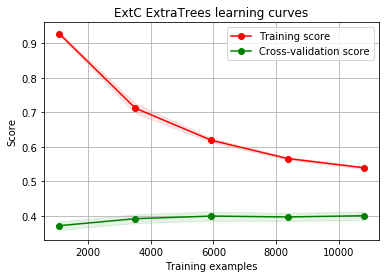

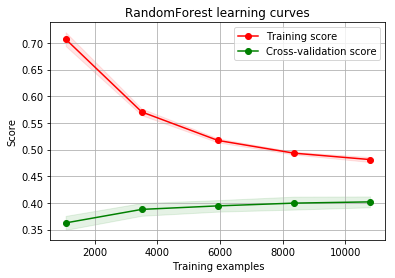

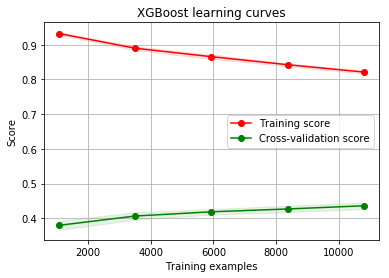

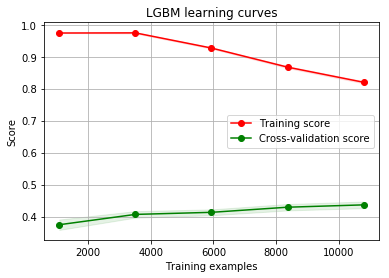

In [17]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt
g = plot_learning_curve(gsExtC.best_estimator_,"ExtC ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsrandom_forest.best_estimator_,"RandomForest learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(xgb_grid.best_estimator_,"XGBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(lgbm_grid.best_estimator_,"LGBM learning curves",X_train,Y_train,cv=kfold)

In [18]:
def get_class_bounds(y, y_pred, N=5, class0_fraction=-1):
    """
    Find boundary values for y_pred to match the known y class percentiles.
    Returns N-1 boundaries in y_pred values that separate y_pred
    into N classes (0, 1, 2, ..., N-1) with same percentiles as y has.
    Can adjust the fraction in Class 0 by the given factor (>=0), if desired. 
    """
    ysort = np.sort(y)
    predsort = np.sort(y_pred)
    bounds = []
    for ibound in range(N-1):
        iy = len(ysort[ysort <= ibound])
        # adjust the number of class 0 predictions?
        if (ibound == 0) and (class0_fraction >= 0.0) :
            iy = int(class0_fraction * iy)
        bounds.append(predsort[iy])
    return bounds

def assign_class(y_pred, boundaries):
    """
    Given class boundaries in y_pred units, output integer class values
    """
    y_classes = np.zeros(len(y_pred))
    for iclass, bound in enumerate(boundaries):
        y_classes[y_pred >= bound] = iclass + 1
    return y_classes.astype(int)

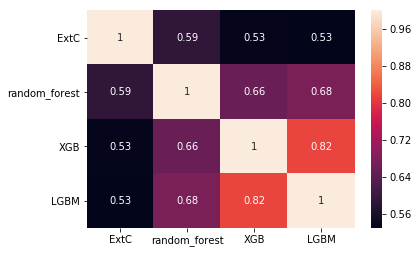

In [19]:
test_Adopted_ExtC = pd.Series(ExtC_best.predict(X_test), name="ExtC")
test_Adopted_random_forest = pd.Series(random_forest_best.predict(X_test), name="random_forest")
test_Adopted_XG = pd.Series(xgb_grid.predict(X_test), name="XGB")
test_Adopted_LGBM = pd.Series(lgbm_grid.predict(X_test), name="LGBM")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Adopted_ExtC, test_Adopted_random_forest, test_Adopted_XG, test_Adopted_LGBM],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)

Drop ExtC since the results do not match when trying to ensemble

In [28]:
VotingPredictor = VotingClassifier(estimators=[('XGB', xgb_best),\
                                               #('ExtC',ExtC_best), 
                                               ('LGBM',lgbm_best), \
                                               ('random_forest', random_forest_best)], voting='soft', n_jobs=4)
VotingPredictor = VotingPredictor.fit(X_train, Y_train)

In [29]:
pickle.dump(VotingPredictor, open("Pet_Vote.pkl", 'wb'))

In [30]:
VotingPredictor_ld = pickle.load(open("Pet_Vote.pkl", 'rb'))

In [32]:
VotingPredictor_predictions = VotingPredictor_ld.predict(X_test)
test_AdoptionSpeed= pd.Series(VotingPredictor_predictions, name="AdoptionSpeed")
PetID = test_copy_df['PetID']

Completed.


In [33]:
# Preparing data for Submission
Submission = pd.concat([PetID,test_Adopted_ExtC, test_Adopted_random_forest, test_Adopted_XG, test_Adopted_LGBM],axis=1)
Submission.head(10)

Submission.to_csv("All_Models_NoBoundariesUsed.csv", index=False)
print("Completed.")

Completed.


In [ ]:
# Preparing data for Submission
Submission = pd.concat([PetID,test_AdoptionSpeed],axis=1)
Submission.head(10)

Submission.to_csv("sample_submission.csv", index=False)
print("Completed.")

Feature Importance


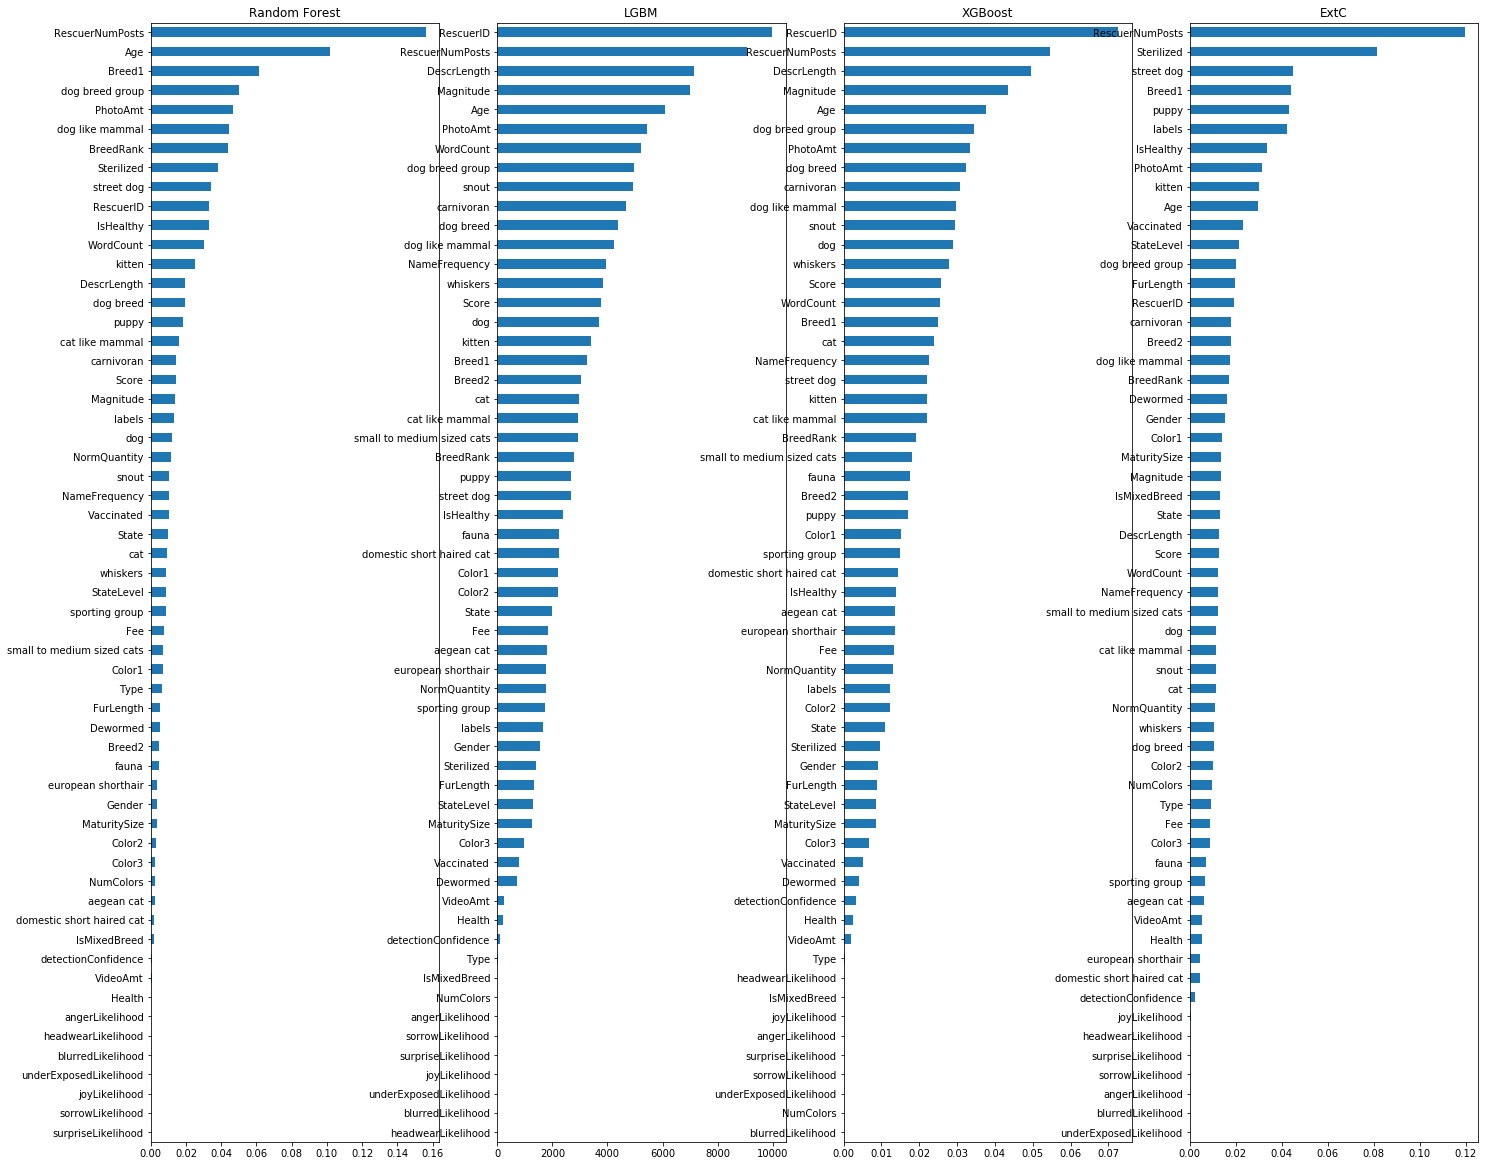

In [27]:
print("Feature Importance")
fig = plt.figure(figsize=(30,70))

plt.subplot(3, 5, 1)
# Create a pd.Series of features importances
importances_rf = pd.Series(random_forest_best.feature_importances_,
index = X_test.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
plt.title("Random Forest")
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh')

plt.subplot(3, 5, 2)
# Create a pd.Series of features importances
importances_rf = pd.Series(lgbm_best.feature_importances_,
index = X_test.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
plt.title("LGBM")
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh')


plt.subplot(3, 5, 3)
# Create a pd.Series of features importances
importances_rf = pd.Series(xgb_best.feature_importances_,
index = X_test.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
plt.title("XGBoost")
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh')
plt.title

plt.subplot(3, 5, 4)
# Create a pd.Series of features importances
importances_rf = pd.Series(ExtC_best.feature_importances_,
index = X_test.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
plt.title("ExtC")
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh')

plt.show()

#SVMC does not have feature importance variables

In [34]:
# This cell calculates and plots the kappa (and MSE) vs the class0 fraction adjustment.
# Note that MSE prefers (lower MSE) a class0 fraction near/at 0,
# whereas kappa prefers (higher kappa) a fraction near 1.
# Then the class0 fraction that gives best training kappa is selected.
train_y = y
df_train = train_copy_df
# Save values of kappa, MSE, and accuracy vs the class0 fraction
kappas = []
mses = []
accurs = []
# fractions to try... (could go larger than 1 if desired.)
cl0fracs = np.array(np.arange(0.01,1.001,0.01))
for cl0frac in cl0fracs:
    boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
    train_meta_ints = assign_class(train_meta, boundaries)
    kappa = cohen_kappa_score(df_train['AdoptionSpeed'], train_meta_ints, weights='quadratic')
    kappas.append(kappa)
    mse = mean_squared_error(df_train['AdoptionSpeed'], train_meta_ints)
    mses.append(mse)
    accur = accuracy_score(df_train['AdoptionSpeed'], train_meta_ints)
    accurs.append(accur)
    
# Use the class0 fraction that gives the highest training kappa
ifmax = np.array(kappas).argmax()
cl0frac = cl0fracs[ifmax]

print("Best kappa for class0 fraction = {:.4f}".format(cl0frac))

NameError: name 'train_meta' is not defined

In [69]:
# Can skip the class0_fraction adjustment and plotting cells above;
# can delete those two cells and just uncomment this line:
##cl0frac = 1.0

print("Using class0_fraction = {:.4f}, gives boundaries:".format(cl0frac))
boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
print(boundaries)

train_meta_ints = assign_class(train_meta, boundaries)
kappa = cohen_kappa_score(train_y, train_meta_ints, weights='quadratic')

print("Adjusted boundaries give:")
print("kappa = {:.4f}  (with accuracy = {:.1f}%)".format(kappa,
                                100.0*accuracy_score(train_y, train_meta_ints)))

Using class0_fraction = 0.3900, gives boundaries:
[1.3889777138829231, 2.069707206916064, 2.469525784254074, 2.8838150026276708]
Adjusted boundaries give:
kappa = 0.4427  (with accuracy = 40.4%)


In [53]:
test_meta_ints = assign_class(test_meta, boundaries)
PetID = test_copy_df['PetID']
testAdoptionSpeed = pd.Series(data=test_meta_ints, name="AdoptionSpeed")
# Preparing data for Submission
Submission = pd.concat([PetID,testAdoptionSpeed],axis=1)
Submission.head(10)

,PetID,AdoptionSpeed
0,378fcc4fc,1
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,4
4,43fbba852,4
5,77a490ec9,4
6,28c4b1b13,4
7,d1eada628,3
8,d134dec34,4
9,bcd464bb8,2
